In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from pathlib import Path
from sklearn import metrics
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision

from datetime import datetime
from collections import OrderedDict

In [2]:
import pickle

In [3]:
PATH = Path("/data2/yinterian/multi-task-romain")

In [4]:
gap = "10min"
gap

'10min'

In [5]:
filename = "data_train_{gap}.pickle".format(gap=gap)
with open(PATH/filename, 'rb') as f:
    train = pickle.load(f)

In [6]:
filename = "data_valid_{gap}.pickle".format(gap=gap)
with open(PATH/filename, 'rb') as f:
    valid = pickle.load(f)

In [7]:
train.head()

,subject_id,key,gender,age,sapsii,sofa,care_unit,amine,sedation,ventilation,prediction_mean_HR,prediction_mean_MAP,series,group
0,10013,10013_16,1,87,49,7,3,1,0,1,95.44,55.88,"[[99.9, 94.2, 107.3, 36.2, 56.7], [107.2, 94.8...",0
1,10013,10013_17,1,87,49,7,3,1,0,1,83.92,70.28,"[[96.0, 92.0, 106.2, 35.2, 55.9], [101.9, 92.7...",0
2,10013,10013_18,1,87,49,7,3,1,0,1,100.14,65.08,"[[0.0, 94.7, 128.5, 43.5, 69.9], [0.0, 94.7, 1...",0
3,10013,10013_21,1,87,49,7,3,1,0,1,102.86,70.6,"[[99.3, 92.0, 126.3, 50.5, 75.6], [100.6, 91.7...",0
4,10013,10013_22,1,87,49,7,3,1,0,1,109.3,61.86,"[[100.7, 93.9, 113.0, 41.6, 66.6], [100.1, 94....",0


In [8]:
valid.head()

,subject_id,key,gender,age,sapsii,sofa,care_unit,amine,sedation,ventilation,prediction_mean_HR,prediction_mean_MAP,series,group
1154,11018,11018_26,0,67,47,1,1,0,0,0,74.3533,71.8733,"[[79.0, 97.0, 99.0, 60.0, 71.0], [79.0, 97.0, ...",1
1155,11018,11018_28,0,67,47,1,1,0,0,0,81.33,78.9333,"[[77.0, 97.0, 103.0, 62.0, 75.0], [76.0, 96.0,...",1
1156,11018,11018_29,0,67,47,1,1,0,0,0,81.2033,79.9233,"[[83.0, 95.0, 111.0, 65.0, 80.0], [84.0, 95.0,...",1
1157,11018,11018_30,0,67,47,1,1,0,0,0,81.3867,83.5367,"[[81.0, 95.0, 114.0, 65.0, 81.0], [81.0, 94.0,...",1
1158,11018,11018_31,0,67,47,1,1,0,0,0,78.67,84.5967,"[[84.0, 95.0, 114.0, 67.0, 81.0], [81.0, 94.0,...",1


In [9]:
train.shape, valid.shape

((50255, 14), (5926, 14))

In [10]:
subject_id_list = np.sort(np.unique(train.subject_id.values))
id2index = {v: k+1 for k,v in enumerate(subject_id_list)}
num_subjects = len(subject_id_list)

In [11]:
num_subjects

2203

## Dataset

In [12]:
def get_mean_std_series(train):
    ss = np.concatenate(train.series.values)
    ss = ss.reshape(-1,5)
    return ss.mean(axis=0), ss.std(axis=0)

In [13]:
def get_mean_std_static(train):
    res = {}
    for name in ["age", "sapsii", "sofa"]:
        values = train[name].values
        res[name] = (values.mean(), values.std())
    res["series"] = get_mean_std_series(train)
    return res

In [14]:
norm_dict = get_mean_std_static(train)
norm_dict 

{'age': (64, 15.057877220725963),
 'sapsii': (33, 14.224363336863284),
 'sofa': (4, 3.7706540212497375),
 'series': (array([ 83.2305084 ,  93.6846448 , 120.9199471 ,  58.75308973,
          78.5877452 ]),
  array([16.09288223, 17.43347146, 21.26444372, 12.27698671, 14.32744073]))}

In [15]:
care2id = {v:k for k,v in enumerate(np.unique(train.care_unit.values))}
care2id 

{1: 0, 2: 1, 3: 2, 5: 3, 6: 4}

In [16]:
class MultiTask(Dataset):
    def __init__(self, df, norm_dict, id2index, care2id,  k=20, train=True):
        """
        Args:
            df: dataframe with data
            norm_dict: mean and std of all variables to normalize
            
        """
        self.norm_dict = norm_dict
        self.df = df
        self.df["care_unit"] = self.df["care_unit"].apply(lambda x: care2id[x])
        self.names = ["age", "sapsii", "sofa"] ## needs normalization
        self.names_binary = ["gender", "amine", "sedation", "ventilation"]
        self.id2index = id2index
        self.train = train
        self.df_sample = self.pick_a_sample(k)
            
    def pick_a_sample(self, k=20):
        """ Picks sample with the same number of observations per patient"""
        if not self.train: # fix seed for validation and test
            np.random.seed(3)
        sample = self.df.groupby("subject_id", group_keys=False).apply(lambda x: x.sample(k, replace=True))
        sample = sample.copy()
        if self.train:
            self.subject_index = [self.id2index[subject_id] for subject_id in sample.subject_id.values]
            self.random = np.random.choice(2, sample.shape[0], p=[0.1, 0.9])
            self.subject_index = self.subject_index*self.random
        return sample

    def __getitem__(self, index):
        row = self.df_sample.iloc[index,:]
        x_series = (row.series - self.norm_dict["series"][0])/self.norm_dict["series"][1]
        x_cont = [(row[name]-self.norm_dict[name][0])/self.norm_dict[name][1] for name in self.names]
        x_binary = [row[name] for name in self.names_binary]
        subject_index = 0
        if self.train:
            subject_index = self.subject_index[index]
        x_cat = np.array([row["care_unit"], subject_index])
        x_cont = np.array(x_cont + x_binary)
        return x_series, x_cont, x_cat, row["prediction_mean_HR"], row["prediction_mean_MAP"]

    def __len__(self):
        return self.df_sample.shape[0]

In [17]:
train_ds = MultiTask(train, norm_dict, id2index, care2id)
valid_ds = MultiTask(valid, norm_dict, id2index, care2id, train=False)

## Model

In [18]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [19]:
class EventModel1(nn.Module):
    def __init__(self, hidden_size=100, num_units=5):
        super(EventModel1, self).__init__()
        self.embedding1 = nn.Embedding(num_units, 1)
        self.embedding2 = nn.Embedding(num_subjects+1, 5)
        self.gru = nn.GRU(5, hidden_size, batch_first=True)
        self.num = hidden_size + 10 + 1 + 5
        self.linear1 = nn.Linear(7, 10)
        self.out1 = nn.Linear(self.num, 1)
        self.out2 = nn.Linear(self.num, 1)
        self.bn1 = nn.BatchNorm1d(10)

    def forward(self, x_series, x_cont, x_cat):
        _, ht = self.gru(x_series)
        x_cat_1 = self.embedding1(x_cat[:,0])
        x_cat_2 = self.embedding2(x_cat[:,1])
        x_cont = self.bn1(F.relu(self.linear1(x_cont))) 
        x = torch.cat((ht[-1], x_cat_1, x_cat_2, x_cont), 1)
        return self.out1(x), self.out2(x)

In [20]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    y_hat1 = []
    ys1 = []
    y_hat2 = []
    ys2 = []
    for x_series, x_cont, x_cat, y1, y2 in valid_dl:
        batch = y1.shape[0]
        x_series = x_series.float().cuda()
        x_cont = x_cont.float().cuda()
        x_cat = x_cat.long().cuda()
        y1 = y1.float().cuda()
        y2 = y2.float().cuda()
        out1, out2 = model(x_series, x_cont, x_cat)
        mse_loss1 = F.mse_loss(out1, y1.unsqueeze(-1))
        mse_loss2 = F.mse_loss(out2, y2.unsqueeze(-1))
        loss = mse_loss1 + mse_loss2
        sum_loss += batch*(loss.item())
        total += batch
        y_hat1.append(out1.view(-1).detach().cpu().numpy())
        ys1.append(y1.view(-1).cpu().numpy())
        y_hat2.append(out2.view(-1).detach().cpu().numpy())
        ys2.append(y2.view(-1).cpu().numpy())
    
    y_hat1 = np.concatenate(y_hat1)
    y_hat2 = np.concatenate(y_hat2)
    ys1 = np.concatenate(ys1)
    ys2 = np.concatenate(ys2)
    r2_1 = metrics.r2_score(ys1, y_hat1)
    r2_2 = metrics.r2_score(ys2, y_hat2)
    return sum_loss/total, r2_1, r2_2

In [21]:
def train_epochs(model, train_ds, optimizer, filename, lr=1e-3, epochs = 30):
    prev_val_r2 = 0
    for i in range(epochs):
        sum_loss1 = 0
        sum_loss2 = 0
        total = 0
        train_ds.pick_a_sample()
        train_dl = DataLoader(train_ds, batch_size=5000, shuffle=True)
        for x_series, x_cont, x_cat, y1, y2 in train_dl:
            model.train()
            x_series = x_series.float().cuda()
            x_cont = x_cont.float().cuda()
            x_cat = x_cat.long().cuda()
            y1 = y1.float().cuda()
            y2 = y2.float().cuda()
            out1, out2 = model(x_series, x_cont, x_cat)
            mse_loss1 = F.mse_loss(out1, y1.unsqueeze(-1))
            mse_loss2 = F.mse_loss(out2, y2.unsqueeze(-1))
            loss = mse_loss1 + mse_loss2
            sum_loss1 += len(y1) * mse_loss1.item()
            sum_loss2 += len(y1) * mse_loss2.item()
            total += len(y1)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if i % 1 == 0:
            val_loss, val_r2_1, val_r2_2 = val_metrics(model, valid_dl)
            print("\tTrain loss: {:.3f} {:.3f} valid loss: {:.3f} valid r2 hr {:.3f} valid r2 map {:.3f}".format(
                sum_loss1/total, sum_loss2/total, val_loss, val_r2_1, val_r2_2))
            
        if val_r2_1 > prev_val_r2:
            prev_val_r2 = val_r2_1
            if val_r2_1 > 0.7:
                path = "{0}/models/{1}_r2_{2:.0f}_{3:.0f}.pth".format(PATH, filename, 100*val_r2_1, 100*val_r2_2) 
                save_model(model, path)
                print(path)

In [22]:
batch_size = 5000
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [23]:
model = EventModel1().cuda()

In [24]:
val_metrics(model, valid_dl)

(13664.217160247093, -27.74101666565972, -32.3480004374181)

In [26]:
# 0s in training
model = EventModel1().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="model1_10min", epochs=15)

	Train loss: 5257.596 4627.143 valid loss: 4987.779 valid r2 hr -9.900 valid r2 map -10.614
	Train loss: 1231.941 953.961 valid loss: 388.307 valid r2 hr 0.025 valid r2 map 0.268
	Train loss: 297.098 236.715 valid loss: 602.937 valid r2 hr -0.388 valid r2 map -0.308
	Train loss: 250.009 149.822 valid loss: 210.197 valid r2 hr 0.469 valid r2 map 0.608
	Train loss: 93.002 75.020 valid loss: 196.575 valid r2 hr 0.546 valid r2 map 0.575
	Train loss: 76.180 67.106 valid loss: 131.563 valid r2 hr 0.716 valid r2 map 0.689
/data2/yinterian/multi-task-romain/models/model1_10min_r2_72_69.pth
	Train loss: 46.535 51.468 valid loss: 123.143 valid r2 hr 0.751 valid r2 map 0.686
/data2/yinterian/multi-task-romain/models/model1_10min_r2_75_69.pth
	Train loss: 41.598 47.691 valid loss: 105.935 valid r2 hr 0.784 valid r2 map 0.732
/data2/yinterian/multi-task-romain/models/model1_10min_r2_78_73.pth
	Train loss: 34.333 42.388 valid loss: 99.711 valid r2 hr 0.794 valid r2 map 0.751
/data2/yinterian/multi-t

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="model1_10min", epochs=20)

	Train loss: 23.851 28.294 valid loss: 69.254 valid r2 hr 0.857 valid r2 map 0.828
/data2/yinterian/multi-task-romain/models/model1_10min_r2_86_83.pth
	Train loss: 18.989 23.281 valid loss: 56.891 valid r2 hr 0.879 valid r2 map 0.863
/data2/yinterian/multi-task-romain/models/model1_10min_r2_88_86.pth
	Train loss: 16.302 20.497 valid loss: 51.211 valid r2 hr 0.890 valid r2 map 0.879
/data2/yinterian/multi-task-romain/models/model1_10min_r2_89_88.pth
	Train loss: 14.481 18.664 valid loss: 44.283 valid r2 hr 0.906 valid r2 map 0.893
/data2/yinterian/multi-task-romain/models/model1_10min_r2_91_89.pth
	Train loss: 13.124 16.968 valid loss: 40.372 valid r2 hr 0.916 valid r2 map 0.900
/data2/yinterian/multi-task-romain/models/model1_10min_r2_92_90.pth
	Train loss: 11.987 16.059 valid loss: 36.176 valid r2 hr 0.926 valid r2 map 0.909
/data2/yinterian/multi-task-romain/models/model1_10min_r2_93_91.pth
	Train loss: 11.197 15.295 valid loss: 32.899 valid r2 hr 0.935 valid r2 map 0.914
/data2/yint

### Model 2

In [28]:
class EventModel2(nn.Module):
    def __init__(self, hidden_size=100):
        super(EventModel2, self).__init__()
        self.embedding1 = nn.Embedding(5, 1)
        self.embedding2 = nn.Embedding(num_subjects+1, 5)
        self.gru = nn.GRU(5, hidden_size, batch_first=True)
        self.num = hidden_size + 1 + 5 + 7
        self.linear1 = nn.Linear(self.num, self.num)
        self.out1 = nn.Linear(self.num, 1)
        self.out2 = nn.Linear(self.num, 1)
        self.bn1 = nn.BatchNorm1d(self.num)
        
    def forward(self, x_series, x_cont, x_cat):
        _, ht = self.gru(x_series)
        x_cat_1 = self.embedding1(x_cat[:,0])
        x_cat_2 = self.embedding2(x_cat[:,1])
        x = torch.cat((ht[-1], x_cat_1, x_cat_2, x_cont), 1)
        x = self.bn1(F.relu(self.linear1(x)))
        return self.out1(x), self.out2(x)

In [29]:
model = EventModel2().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="model2_10min", epochs=15)

	Train loss: 6335.327 5667.724 valid loss: 7564.138 valid r2 hr -14.477 valid r2 map -18.054
	Train loss: 2097.908 1891.322 valid loss: 75.502 valid r2 hr 0.857 valid r2 map 0.794
/data2/yinterian/multi-task-romain/models/model2_10min_r2_86_79.pth
	Train loss: 467.389 459.560 valid loss: 757.694 valid r2 hr -0.259 valid r2 map -1.307
	Train loss: 118.740 116.557 valid loss: 249.179 valid r2 hr 0.449 valid r2 map 0.428
	Train loss: 127.543 134.345 valid loss: 36.813 valid r2 hr 0.937 valid r2 map 0.890
/data2/yinterian/multi-task-romain/models/model2_10min_r2_94_89.pth
	Train loss: 27.074 35.689 valid loss: 100.116 valid r2 hr 0.816 valid r2 map 0.719
	Train loss: 18.161 23.768 valid loss: 40.769 valid r2 hr 0.930 valid r2 map 0.879
	Train loss: 13.778 19.059 valid loss: 22.881 valid r2 hr 0.971 valid r2 map 0.918
/data2/yinterian/multi-task-romain/models/model2_10min_r2_97_92.pth
	Train loss: 8.783 12.925 valid loss: 23.490 valid r2 hr 0.969 valid r2 map 0.918
	Train loss: 7.388 11.429

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="model2_10min", epochs=20)

	Train loss: 23.997 26.460 valid loss: 81.560 valid r2 hr 0.905 valid r2 map 0.696
/data2/yinterian/multi-task-romain/models/model2_10min_r2_90_70.pth
	Train loss: 11.843 16.211 valid loss: 29.989 valid r2 hr 0.956 valid r2 map 0.901
/data2/yinterian/multi-task-romain/models/model2_10min_r2_96_90.pth
	Train loss: 8.449 11.783 valid loss: 23.853 valid r2 hr 0.969 valid r2 map 0.915
/data2/yinterian/multi-task-romain/models/model2_10min_r2_97_92.pth
	Train loss: 6.685 10.764 valid loss: 23.307 valid r2 hr 0.970 valid r2 map 0.917
/data2/yinterian/multi-task-romain/models/model2_10min_r2_97_92.pth
	Train loss: 6.508 10.311 valid loss: 22.168 valid r2 hr 0.971 valid r2 map 0.922
/data2/yinterian/multi-task-romain/models/model2_10min_r2_97_92.pth
	Train loss: 6.174 9.923 valid loss: 22.249 valid r2 hr 0.971 valid r2 map 0.921
/data2/yinterian/multi-task-romain/models/model2_10min_r2_97_92.pth
	Train loss: 5.902 9.547 valid loss: 22.306 valid r2 hr 0.970 valid r2 map 0.922
	Train loss: 5.968

In [31]:
train_epochs(model, train_ds, optimizer, filename="model2_10min", epochs=10)

	Train loss: 5.169 7.845 valid loss: 23.169 valid r2 hr 0.972 valid r2 map 0.916
/data2/yinterian/multi-task-romain/models/model2_10min_r2_97_92.pth
	Train loss: 5.128 7.793 valid loss: 23.329 valid r2 hr 0.971 valid r2 map 0.915
	Train loss: 5.181 7.575 valid loss: 22.683 valid r2 hr 0.974 valid r2 map 0.916
/data2/yinterian/multi-task-romain/models/model2_10min_r2_97_92.pth
	Train loss: 5.155 7.513 valid loss: 23.417 valid r2 hr 0.972 valid r2 map 0.914
	Train loss: 4.976 7.409 valid loss: 23.713 valid r2 hr 0.971 valid r2 map 0.913
	Train loss: 5.014 7.494 valid loss: 22.754 valid r2 hr 0.972 valid r2 map 0.917
	Train loss: 4.952 7.523 valid loss: 24.576 valid r2 hr 0.971 valid r2 map 0.909
	Train loss: 5.060 7.462 valid loss: 23.616 valid r2 hr 0.972 valid r2 map 0.913
	Train loss: 5.107 7.560 valid loss: 23.788 valid r2 hr 0.971 valid r2 map 0.913
	Train loss: 5.515 7.653 valid loss: 23.850 valid r2 hr 0.966 valid r2 map 0.919


## Model 3

In [25]:
class EventModel3(nn.Module):
    def __init__(self, hidden_size=100, num2=50):
        super(EventModel3, self).__init__()
        self.embedding1 = nn.Embedding(5, 1)
        self.embedding2 = nn.Embedding(num_subjects+1, 5)
        self.gru = nn.GRU(5, hidden_size, batch_first=True)
        self.num1 = hidden_size + 1 + 5 + 7
        self.num2 = num2
        self.linear1 = nn.Linear(self.num1, self.num2)
        self.linear2 = nn.Linear(self.num2, self.num2)
        self.out1 = nn.Linear(self.num2, 1)
        self.out2 = nn.Linear(self.num2, 1)
        self.bn1 = nn.BatchNorm1d(self.num2)
        self.bn2 = nn.BatchNorm1d(self.num2)
        
    def forward(self, x_series, x_cont, x_cat):
        _, ht = self.gru(x_series)
        x_cat_1 = self.embedding1(x_cat[:,0])
        x_cat_2 = self.embedding2(x_cat[:,1])
        x = torch.cat((ht[-1], x_cat_1, x_cat_2, x_cont), 1)
        x = self.bn1(F.relu(self.linear1(x)))
        x = self.bn2(F.relu(self.linear2(x)))
        return self.out1(x), self.out2(x)

In [26]:
model = EventModel3().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="model3_10min", epochs=15)

	Train loss: 6900.162 6100.769 valid loss: 12150.911 valid r2 hr -22.746 valid r2 map -31.134
	Train loss: 5750.591 5068.362 valid loss: 7035.059 valid r2 hr -12.039 valid r2 map -18.575
	Train loss: 3621.682 3089.900 valid loss: 3340.879 valid r2 hr -5.583 valid r2 map -7.761
	Train loss: 1214.414 926.356 valid loss: 247.116 valid r2 hr 0.346 valid r2 map 0.581
	Train loss: 81.374 72.419 valid loss: 325.350 valid r2 hr 0.476 valid r2 map -0.013
	Train loss: 153.194 195.323 valid loss: 255.640 valid r2 hr 0.482 valid r2 map 0.349
	Train loss: 50.132 47.554 valid loss: 31.231 valid r2 hr 0.954 valid r2 map 0.897
/data2/yinterian/multi-task-romain/models/model3_10min_r2_95_90.pth
	Train loss: 15.863 28.936 valid loss: 64.268 valid r2 hr 0.874 valid r2 map 0.830
	Train loss: 15.530 24.040 valid loss: 23.048 valid r2 hr 0.971 valid r2 map 0.917
/data2/yinterian/multi-task-romain/models/model3_10min_r2_97_92.pth
	Train loss: 7.975 12.546 valid loss: 27.687 valid r2 hr 0.962 valid r2 map 0.9

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="model3_10min", epochs=15)

	Train loss: 17.047 18.838 valid loss: 52.256 valid r2 hr 0.932 valid r2 map 0.815
/data2/yinterian/multi-task-romain/models/model3_10min_r2_93_81.pth
	Train loss: 9.098 12.728 valid loss: 38.706 valid r2 hr 0.913 valid r2 map 0.913
	Train loss: 7.334 10.874 valid loss: 30.361 valid r2 hr 0.946 valid r2 map 0.913
/data2/yinterian/multi-task-romain/models/model3_10min_r2_95_91.pth
	Train loss: 6.737 10.088 valid loss: 20.322 valid r2 hr 0.975 valid r2 map 0.927
/data2/yinterian/multi-task-romain/models/model3_10min_r2_97_93.pth
	Train loss: 6.314 9.748 valid loss: 19.998 valid r2 hr 0.974 valid r2 map 0.929
	Train loss: 6.122 9.563 valid loss: 20.002 valid r2 hr 0.975 valid r2 map 0.928
/data2/yinterian/multi-task-romain/models/model3_10min_r2_97_93.pth
	Train loss: 5.929 9.393 valid loss: 20.980 valid r2 hr 0.972 valid r2 map 0.927
	Train loss: 5.752 9.011 valid loss: 19.570 valid r2 hr 0.976 valid r2 map 0.929
/data2/yinterian/multi-task-romain/models/model3_10min_r2_98_93.pth
	Train 

## Calibration plot

In [28]:
path = PATH/"models/model3_10min_r2_98_93.pth"
model = EventModel3().cuda()
load_model(model, path)

In [29]:
# external data
filename = "data_validation_10min.pickle"
with open(PATH/filename, 'rb') as f:
    test_ext = pickle.load(f)

In [30]:
filename = "data_test_{gap}.pickle".format(gap=gap)
with open(PATH/filename, 'rb') as f:
    test = pickle.load(f)
print(filename)

data_test_10min.pickle


In [31]:
test_ds = MultiTask(test, norm_dict, id2index, care2id, k=13, train=False)
test_ext_ds = MultiTask(test_ext, norm_dict, id2index, care2id, k=13, train=False)
test.shape, len(test_ds), len(test_ext_ds)

((7002, 14), 3627, 702)

In [34]:
test_dl = DataLoader(test_ds, batch_size=len(test_ds))
test_ext_dl = DataLoader(test_ext_ds, batch_size=len(test_ext_ds))

In [35]:
val_metrics(model, test_dl)

(17.702816009521484, 0.9748178666085353, 0.9384027564277532)

In [36]:
val_metrics(model, test_ext_dl)

(83.73110961914062, 0.9020272898705173, 0.8502321559485337)

In [39]:
def predict_one_batch(model, dl):
    for x_series, x_cont, x_cat, y1, y2 in dl:
        x_series = x_series.float().cuda()
        x_cont = x_cont.float().cuda()
        x_cat = x_cat.long().cuda()
        y1 = y1.float().cuda()
        y2 = y2.float().cuda()
        out1, out2 = model(x_series, x_cont, x_cat)
    return out1.detach().cpu().numpy(), out2.detach().cpu().numpy(), y1.detach().cpu().numpy(), y2.detach().cpu().numpy()

In [40]:
out1, out2, y1, y2 = predict_one_batch(model, test_dl)

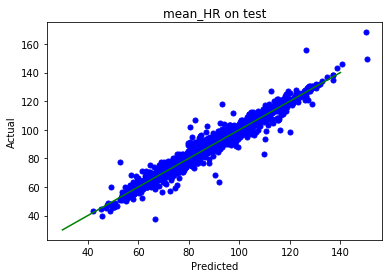

In [41]:
x = np.linspace(30, 140, 1000)
plt.plot(out1, y1, 'bo', ms=5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("mean_HR on test")
plt.plot(x, x, '-g')
plt.show()

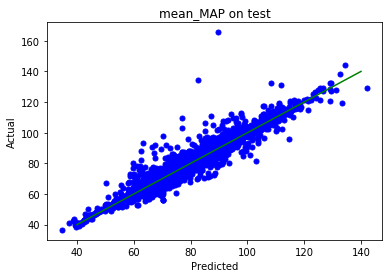

In [42]:
x = np.linspace(40, 140, 1000)
plt.plot(out2, y2, 'bo', ms=5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("mean_MAP on test")
plt.plot(x, x, '-g')
plt.show()